# Turbofan POC - Data Analysis

This notebook is a compact analysis of the initial dataset for the turbofan POC based on the NASA turbofan dataset.

## Imports

In [1]:
# check if we are inside google colab
try:
    from google.colab import drive
    # mount gdrive for importing the data
    drive.mount('/content/gdrive', force_remount=True)
    # change this path to your notebooks directory inside google drive
    %cd /content/gdrive/My\ Drive/dev/turbofan_poc/notebooks

    # set tensorflow version
    %tensorflow_version 2.x
except:
    pass

Mounted at /content/gdrive
/content/gdrive/My Drive/dev/turbofan_poc/notebooks
TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import pandas as pd
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Data Import and Preparations

Let´s load the dataset with our initial training data.

In [3]:
# load the data 
dirname = os.getcwd()
data_path = os.path.join(dirname, '../data')
train_data_path = os.path.join(data_path, 'train_data_initial.txt')
train_data = pd.read_csv(train_data_path)
train_data.set_index('time_in_cycles')

train_data.sample(5)

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
32,80,33,0.0016,-0.0003,100.0,518.67,642.72,1591.63,1412.88,14.62,21.61,554.13,2388.10,9055.75,1.3,47.62,521.62,2388.09,8137.43,8.4606,0.03,392,2388,100.0,38.62,23.1953,NaN,NaN
952,21,178,0.0002,0.0003,100.0,518.67,643.16,1595.14,1415.78,14.62,21.61,552.41,2388.13,9115.87,1.3,47.92,520.47,2388.11,8191.23,8.5123,0.03,395,2388,100.0,38.53,23.1336,NaN,NaN
152,80,153,-0.0022,-0.0001,100.0,518.67,642.68,1595.62,1415.44,14.62,21.61,552.58,2388.10,9104.78,1.3,47.71,520.53,2388.16,8174.12,8.4727,0.03,395,2388,100.0,38.52,23.1728,NaN,NaN
371,54,187,0.0007,-0.0001,100.0,518.67,642.56,1593.65,1398.96,14.62,21.61,552.76,2388.05,9083.80,1.3,47.55,521.57,2388.05,8163.27,8.4335,0.03,393,2388,100.0,38.82,23.4252,NaN,NaN
727,29,116,0.0010,0.0002,100.0,518.67,642.77,1597.18,1412.73,14.62,21.61,553.75,2388.11,9054.34,1.3,47.62,520.96,2388.15,8129.72,8.4833,0.03,395,2388,100.0,38.80,23.2955,NaN,NaN


There is an engine number defining the original engine data series, there is the current cycle and then there are 3 operational settings and 23 sensors.

Now we need to add the labels to the data calculating the max cycle per engine and then adding the current RUL per engine.

In [4]:
# retrieve the max cycles per engine: RUL
train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
# merge the RULs into the training data
train_rul.columns = ['engine_no', 'max']
train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
# add the current RUL for every cycle
train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
train_data.drop('max', axis=1, inplace=True)
train_data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,RUL
0,80,1,-0.0037,0.0002,100.0,518.67,642.66,1588.30,1392.25,14.62,21.61,553.30,2388.17,9052.54,1.3,47.44,521.76,2388.13,8130.23,8.4377,0.03,393,2388,100.0,38.66,23.2146,NaN,NaN,184
1,80,2,0.0008,-0.0001,100.0,518.67,642.55,1590.37,1413.83,14.62,21.61,554.33,2388.08,9047.61,1.3,47.62,521.62,2388.12,8136.26,8.4602,0.03,393,2388,100.0,38.83,23.3626,NaN,NaN,183
2,80,3,0.0004,-0.0005,100.0,518.67,643.62,1586.74,1408.62,14.62,21.61,553.94,2388.12,9055.27,1.3,47.46,521.51,2388.10,8131.42,8.3990,0.03,393,2388,100.0,38.78,23.2833,NaN,NaN,182
3,80,4,0.0007,-0.0003,100.0,518.67,643.04,1589.60,1412.19,14.62,21.61,553.18,2388.13,9047.89,1.3,47.51,520.98,2388.09,8133.99,8.4308,0.03,395,2388,100.0,39.01,23.3077,NaN,NaN,181
4,80,5,-0.0032,-0.0001,100.0,518.67,642.10,1587.23,1408.13,14.62,21.61,552.94,2388.13,9057.00,1.3,47.59,521.22,2388.09,8127.56,8.4253,0.03,393,2388,100.0,38.92,23.1403,NaN,NaN,180


## Data Analysis

### Basic Information

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 969
Data columns (total 29 columns):
engine_no                970 non-null int64
time_in_cycles           970 non-null int64
operational_setting_1    970 non-null float64
operational_setting_2    970 non-null float64
operational_setting_3    970 non-null float64
sensor_measurement_1     970 non-null float64
sensor_measurement_2     970 non-null float64
sensor_measurement_3     970 non-null float64
sensor_measurement_4     970 non-null float64
sensor_measurement_5     970 non-null float64
sensor_measurement_6     970 non-null float64
sensor_measurement_7     970 non-null float64
sensor_measurement_8     970 non-null float64
sensor_measurement_9     970 non-null float64
sensor_measurement_10    970 non-null float64
sensor_measurement_11    970 non-null float64
sensor_measurement_12    970 non-null float64
sensor_measurement_13    970 non-null float64
sensor_measurement_14    970 non-null float64
sensor_measurement_15    

In [6]:
# check how many original turbofan engine series we have
len(train_data['engine_no'].unique())

5

There are 5 complete time series of turbofan engine data.

We remove the empty sensors.

In [7]:
cols_nan = train_data.columns[train_data.isna().any()].tolist()
print('Columns without data: \n' + str(cols_nan) + '\n')

train_data = train_data.drop(columns=cols_nan)

Columns without data: 
['sensor_measurement_22', 'sensor_measurement_23']



In [0]:
# define column sets for the analysis
info_cols = ['engine_no', 'time_in_cycles', 'RUL']
operational_cols = ['operational_setting_{}'.format(i + 1) for i in range (3)]
sensor_cols = ['sensor_measurement_{}'.format(i + 1) for i in range(21)]

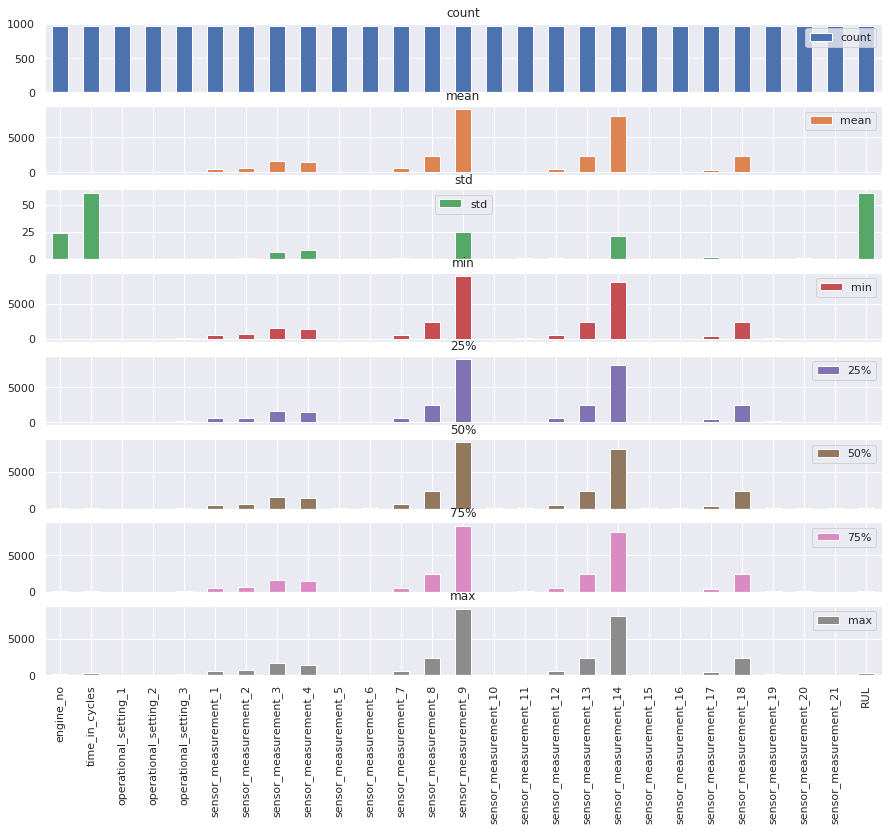

In [9]:
# plot an overview of whats going on in the columns
axes = train_data.describe().T.plot.bar(subplots=True, figsize=(15,12))

There are some sensors with constant constant values:

In [10]:
cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')

Columns with constant values: 
['operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']



### Correlations

Check the correlations:

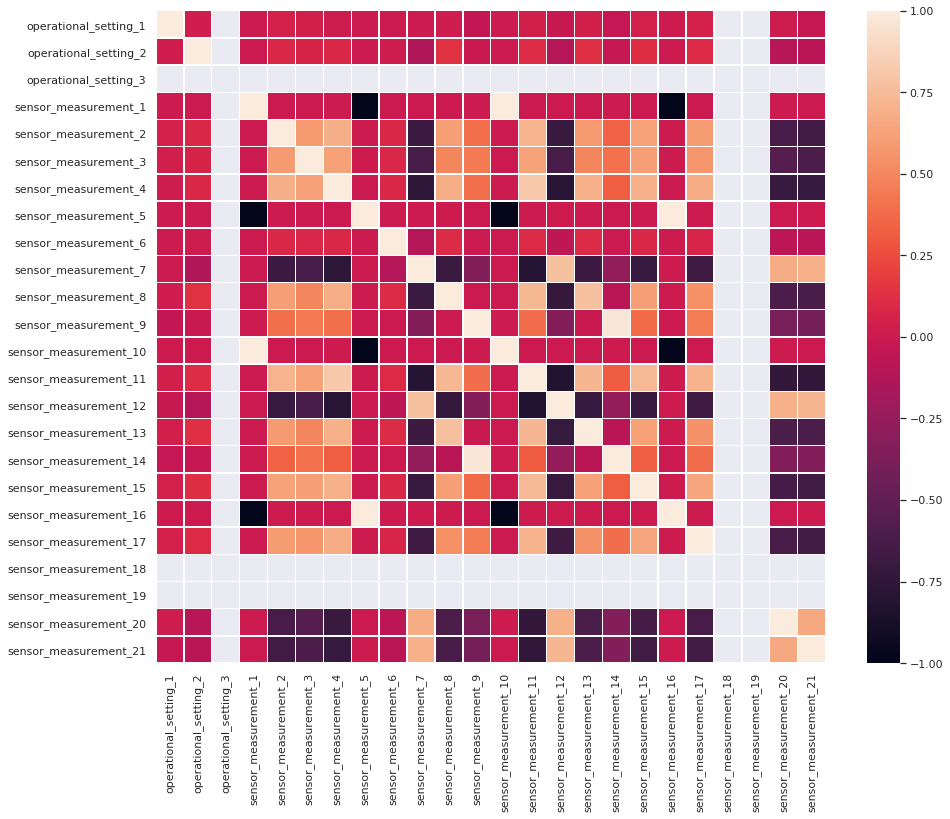

In [11]:
# print correlation heatmap
analysis_data_corr = train_data[operational_cols + sensor_cols].corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(analysis_data_corr, linewidths=.5)

In [12]:
# print highly correlated values
analysis_data_corr2 = pd.DataFrame(np.tril(analysis_data_corr.values), columns=analysis_data_corr.columns, index = analysis_data_corr.index)

correlating = []
for col in analysis_data_corr2.columns:
    ser = analysis_data_corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c))

print('Highly correlating values:')
for c in correlating:
    print(c)

Highly correlating values:
('sensor_measurement_1', 'sensor_measurement_5', -1.0)
('sensor_measurement_1', 'sensor_measurement_10', 1.0)
('sensor_measurement_1', 'sensor_measurement_16', -1.0)
('sensor_measurement_4', 'sensor_measurement_11', 0.8156824417981781)
('sensor_measurement_5', 'sensor_measurement_10', -1.0)
('sensor_measurement_5', 'sensor_measurement_16', 1.0)
('sensor_measurement_7', 'sensor_measurement_11', -0.8006732891425309)
('sensor_measurement_9', 'sensor_measurement_14', 0.9721827662430339)
('sensor_measurement_10', 'sensor_measurement_16', -1.0)
('sensor_measurement_11', 'sensor_measurement_12', -0.8170955553283218)


Sensor 1, 5, 10 and 16 have constant values so we can ignore these correlations.

### Time and Distribution Plots

We will start with plotting the sensor data for all engines in a row. 

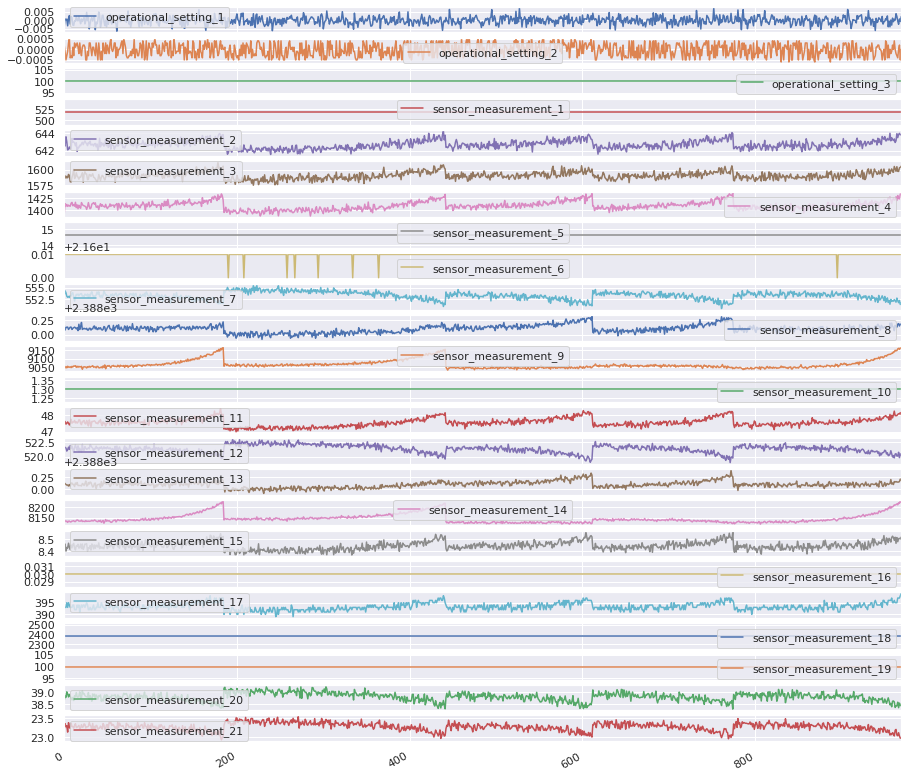

In [13]:
# plot all train data by sensors
t = train_data[operational_cols + sensor_cols].plot(subplots=True, figsize=(15, 15))

Now we plot the train data but grouped by our engines.

In [0]:
# inverse the RUL for the plot
train_data['RUL'] = train_data['RUL'] * -1

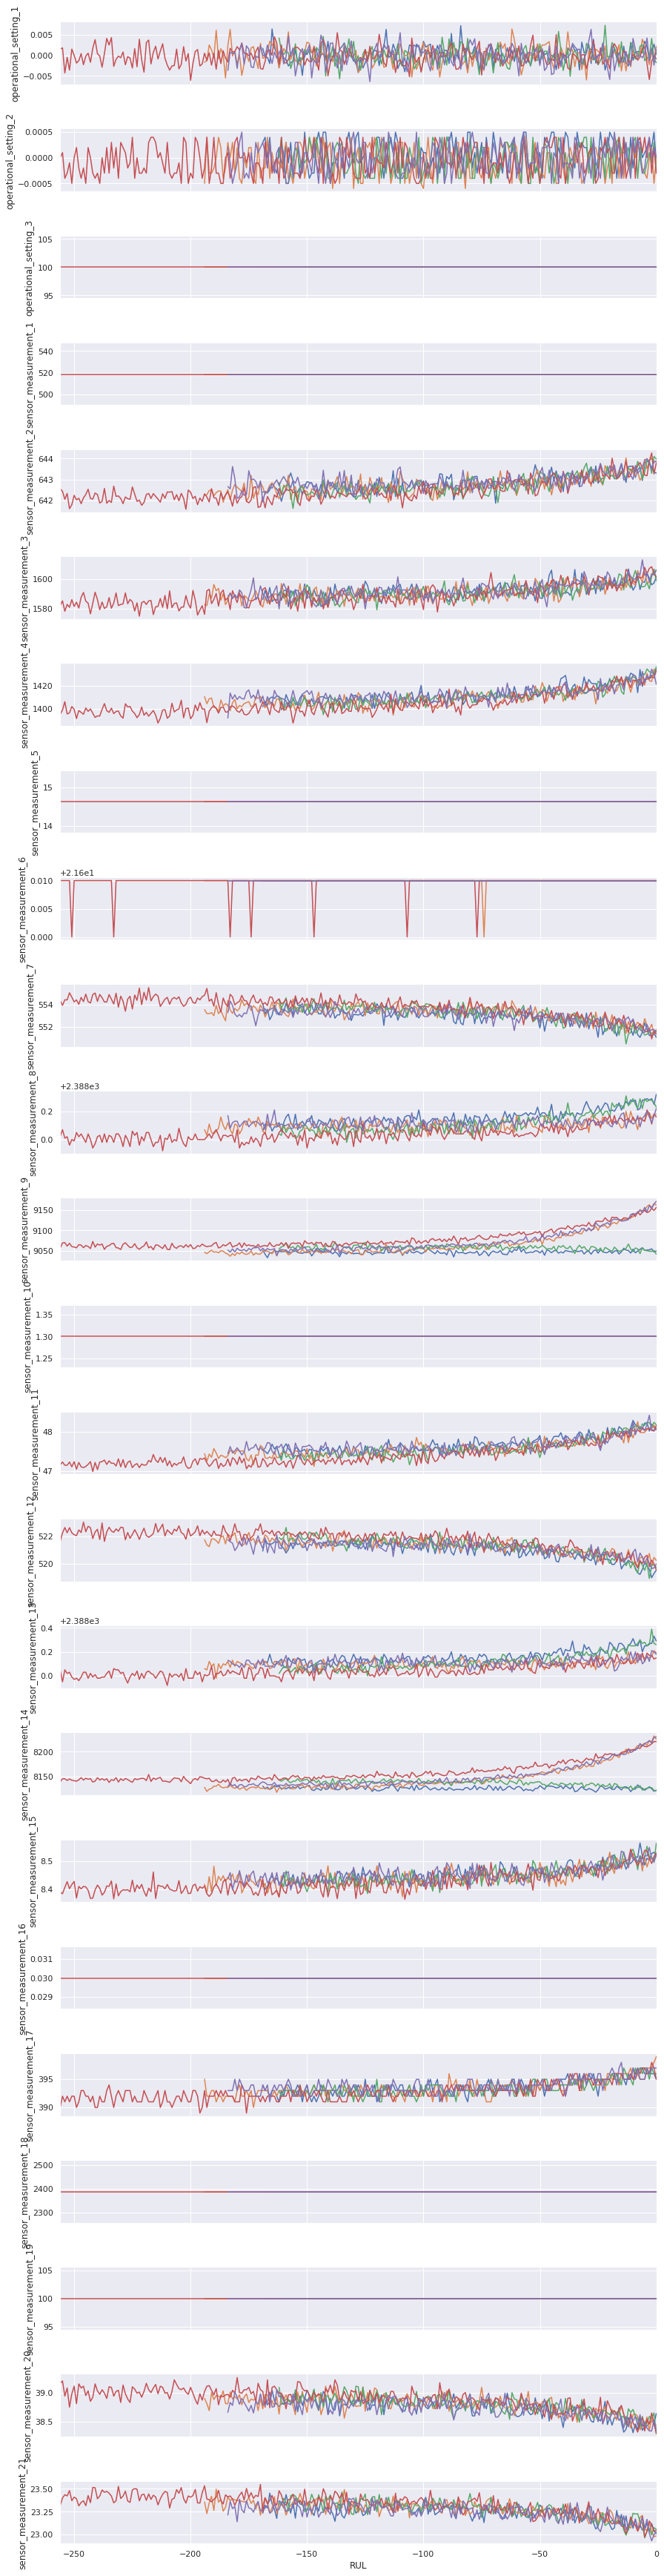

In [15]:
# plot all engines sensor data
g = sns.PairGrid(data=train_data, x_vars='RUL', y_vars=operational_cols+sensor_cols, hue="engine_no", height=2, aspect=6,)
g = g.map(plt.plot)
g = g.set(xlim=(train_data['RUL'].min(), train_data['RUL'].max()))

Let´s plot a single engine and try several engines.

In [16]:
train_data.groupby(['engine_no'], sort=False)['time_in_cycles'].max().sort_values()

engine_no
29    163
12    170
80    185
21    195
54    257
Name: time_in_cycles, dtype: int64

The engine with the shortest cycles is nr. 29 with 163 cycles lifetime and the one with the longest cycles run is nr. 54 running 257 cycles.

In [0]:
# plot a single engines sensor data
def plot_engine_data(engine_no, engine_data):
  window_size = 20
  cols = engine_data.columns
  fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))

  for col, ax in zip(cols, axes):
      engine_data[col].plot(ax = ax)
      engine_data[col].rolling(window_size).median().plot(ax = ax)
      engine_data[col].rolling(window_size).mean().plot(style = '--', legend=True, ax = ax)
  fig.suptitle('Engine Nr: {}'.format(engine_no))

In [0]:
# plot a single engines hists
def plot_engine_hists(engine_data):
  cols = engine_data.columns
  n_cols = min(len(cols), 4)
  n_rows = int(np.ceil(len(cols) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
  plt.tight_layout()
  axes = axes.flatten()
  for col, ax in zip(cols, axes):
      sns.distplot(engine_data[[col]], ax=ax, label=col)
      ax.set_xlabel(col)
      ax.set_ylabel("p")

In [0]:
def plot_engine(engine_no):
  window_size = 20
  engine_data = train_data[train_data.engine_no == engine_no]
  engine_data = engine_data.drop(columns=['engine_no', 'RUL'])
  # drop constant values
  engine_data = engine_data.drop(columns=cols_const)

  plot_engine_data(engine_no, engine_data)
  plot_engine_hists(engine_data)

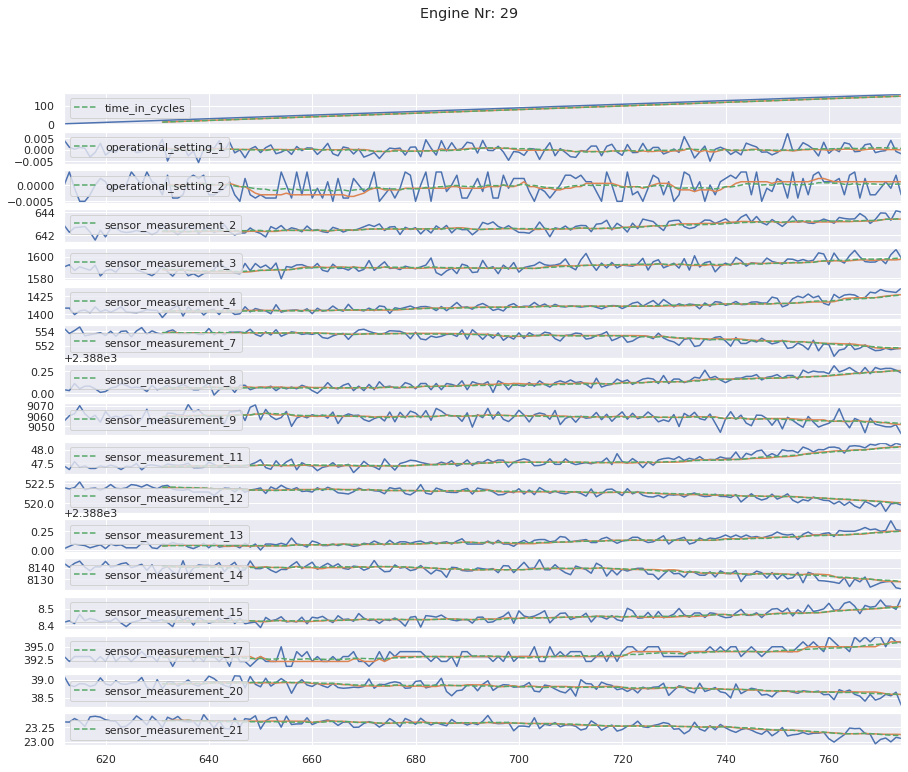

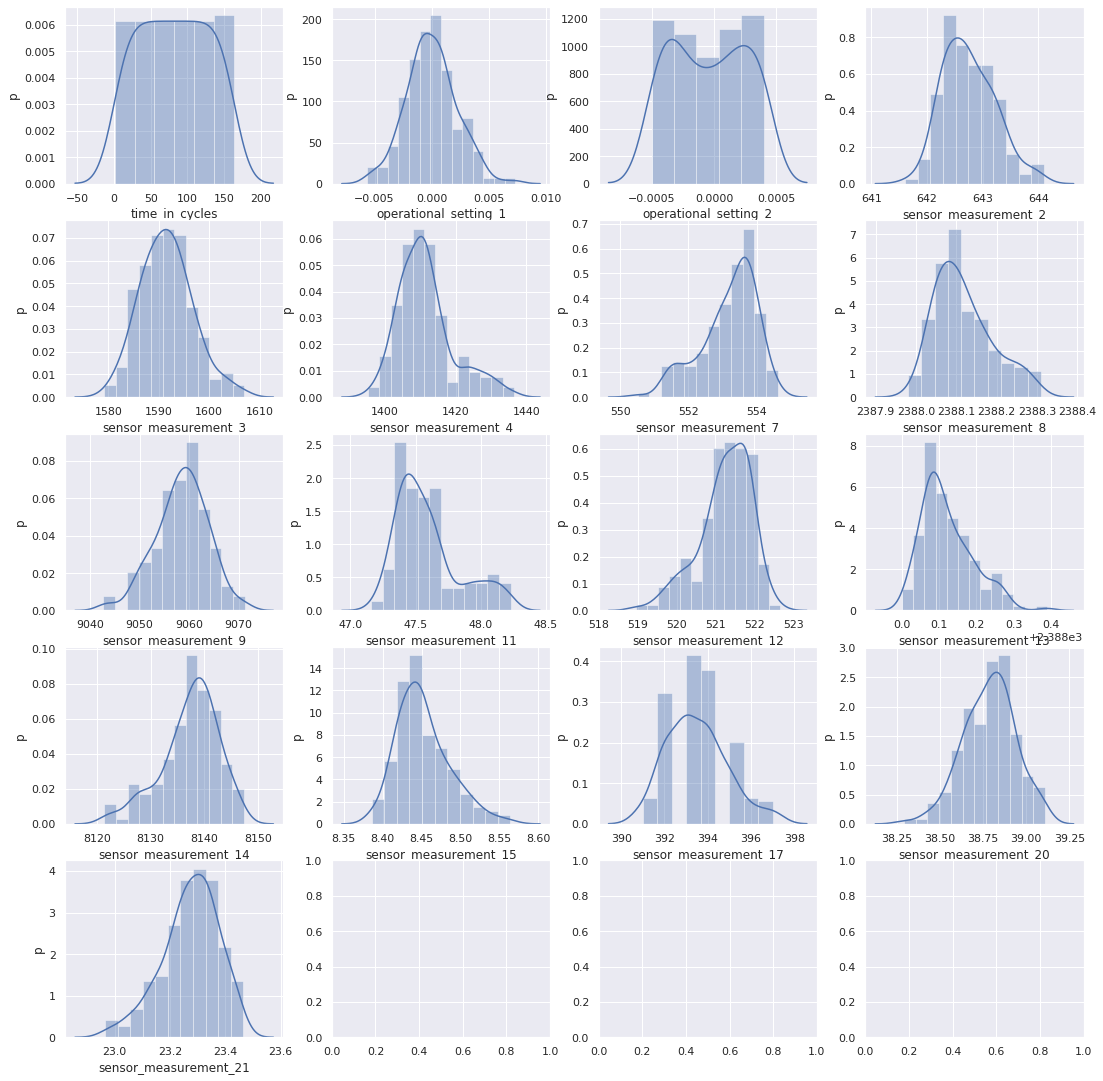

In [24]:
# plot engine with the shortest cycles
plot_engine(29)

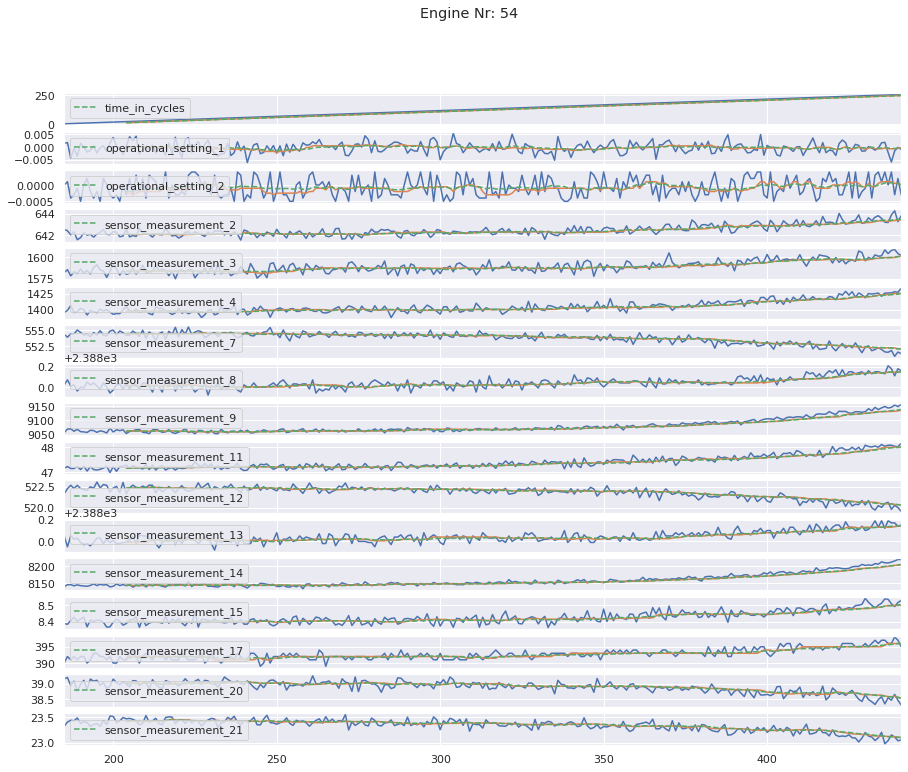

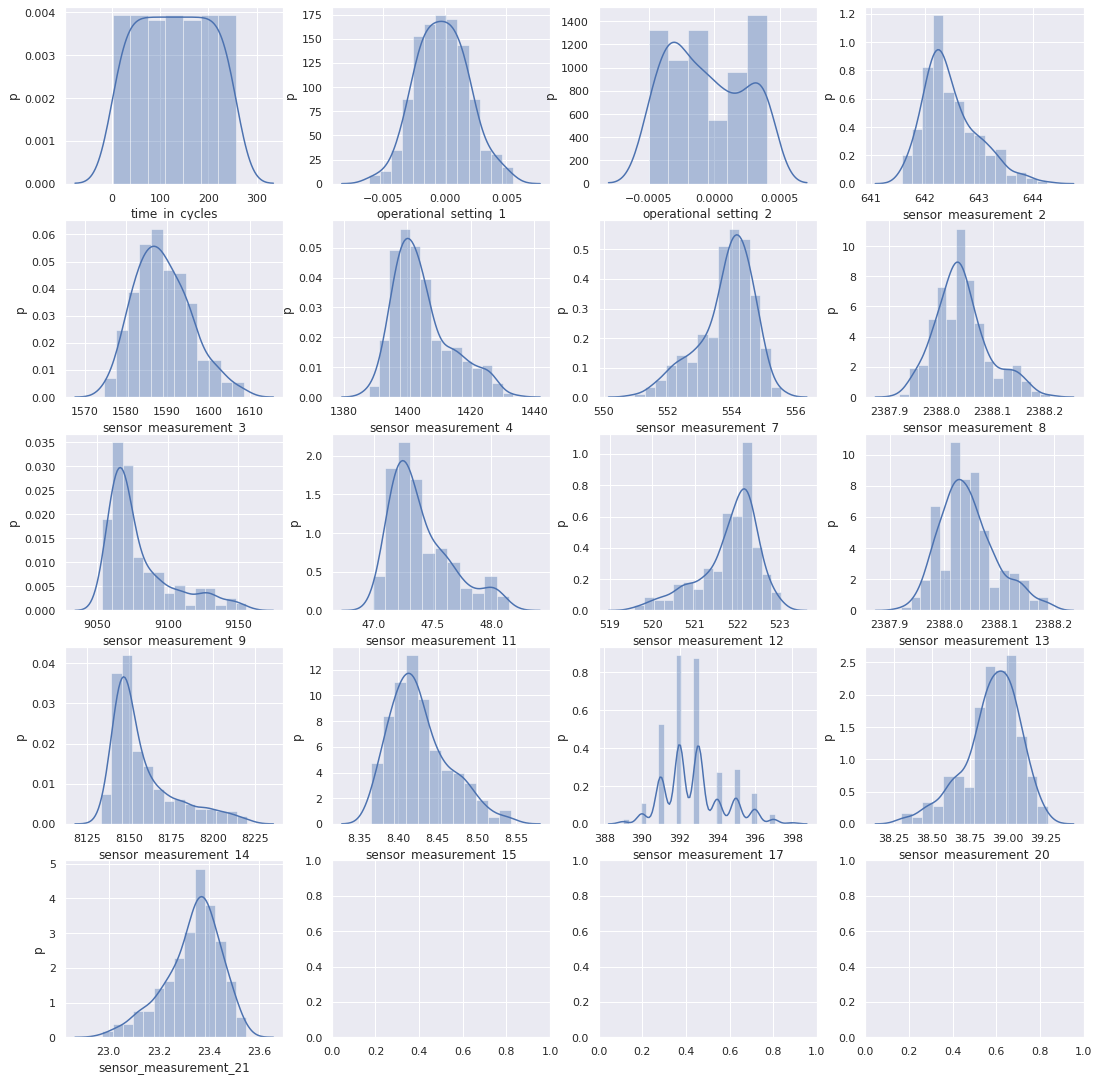

In [25]:
# plot engine with the longest cycles
plot_engine(54)

Let´s have a look at the number of cycles the engines run before a failure.

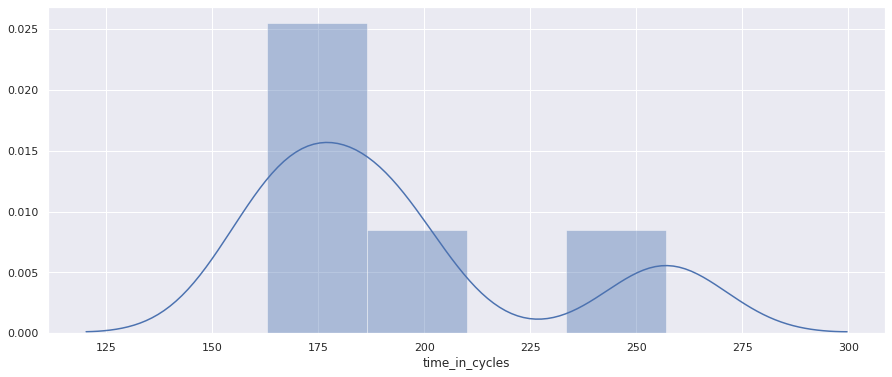

In [26]:
cycles_per_engine = train_data.groupby(['engine_no'], sort=False)['time_in_cycles'].max()
fig = plt.figure(figsize=(15, 6))
ax2 = sns.distplot(pd.Series(cycles_per_engine) ,label='operation times')